we are going to learn how to plot GradCam in PyTorch.

To get the GradCam outputs, we need the activation maps and the gradients of those activation maps.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
from skimage.io import imread
from skimage.transform import resize

We are going to use hooks to get the activation maps and the gradients from the desired layer and tensor, respectively. For this tutorial, we are going to take the activation maps from layer4 of ResNet50 and gradients with respect to the output tensor of the same.

In [2]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        #PRETRAINED MODEL
        self.pretrained = models.resnet50(pretrained=True)
        self.layerhook.append(self.pretrained.layer4.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

We add a forward hook to the layer of the ResNet50 model. The forward hook takes as arguments, the input to the layer and the output from the layer. 

To the output tensor, we register a hook using the register_hook method. This method registers a backward hook to a tensor and is called every time gradient is computed with respect to the tensor. Its input argument is the gradient with respect to that output tensor.

In [3]:
# model instance

gcmodel = GradCamModel() #.to(‘cuda:0’)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [4]:
img = imread('tiger.jpg') #'bulbul.jpg' tiger.jpg
img = resize(img, (224,224), preserve_range = True)
img = np.expand_dims(img.transpose((2,0,1)),0)
img /= 255.0
mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
img = (img - mean)/std
inpimg = torch.from_numpy(img).to('cpu',torch.float32)

In [5]:
out, acts = gcmodel(inpimg)
acts = acts.detach()

print(out.shape, acts.shape)

torch.Size([1, 1000]) torch.Size([1, 2048, 7, 7])


In [6]:

loss = nn.CrossEntropyLoss()(out,torch.from_numpy(np.array([600]))) #.to(‘cuda:0’)) #tiger 600
loss.backward()

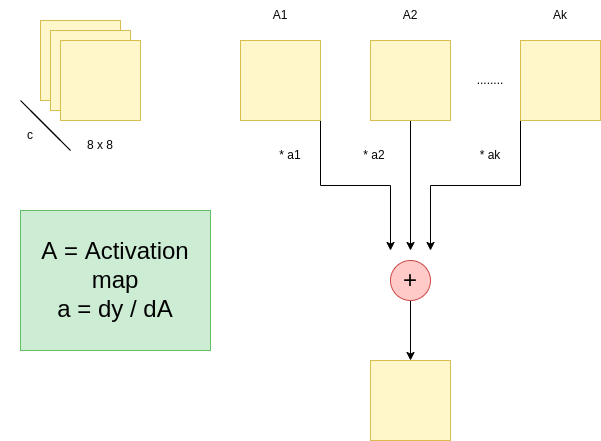

In [7]:
grads = gcmodel.get_act_grads().detach().cpu()

print(grads.shape)

torch.Size([1, 2048, 7, 7])


In [8]:
pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()

print(pooled_grads.shape)

torch.Size([2048])


In [9]:
for i in range(acts.shape[1]):
  acts[:,i,:,:] += pooled_grads[i]

In [10]:
heatmap_j = torch.mean(acts, dim = 1).squeeze()
heatmap_j_max = heatmap_j.max(axis = 0)[0]
heatmap_j /= heatmap_j_max

In [11]:
heatmap_j = resize(heatmap_j.numpy(),(224,224),preserve_range=True)

In [12]:
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.6)

<ipython-input-12-9993036dbd30>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet',256)


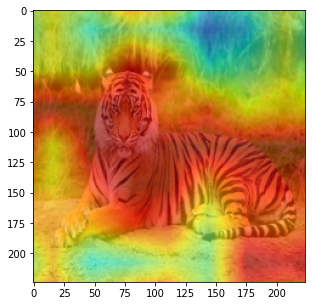

In [13]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow((img*std+mean)[0].transpose(1,2,0))
axs.imshow(heatmap_j2)
plt.show()

In [16]:
# Other visualization


heatmap_j3 = (heatmap_j > 0.75)

#heatmap_j3 = cmap(heatmap_j3,alpha = 0.6)

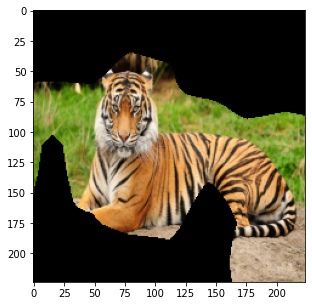

In [17]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
hmap =  ((img*std+mean)[0].transpose(1,2,0)) * np.expand_dims(heatmap_j3, axis = -1) 
axs.imshow(hmap)

plt.show()